In [1]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
from utils import *
from functions import *
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture 
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import validation_curve

os.environ['TF_ENABLE_ONEDNN_OPTS']='0'

from sklearn.metrics import adjusted_mutual_info_score

import os
import scipy.io

from sklearn.decomposition import PCA

In [4]:
# Load dataset from file
folder_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'

# List all .mat files in the folder and load them
cnc_maps = scipy.io.loadmat(folder_path + 'cncMaps.mat')['cncMaps'][:80, :80, :]
esc_maps = scipy.io.loadmat(folder_path + 'escMaps.mat')['escMaps'][:80, :80, :]

# Load polys data and then perform linear interpolation
# List all .mat files in the folder and load them
cnc_polys = scipy.io.loadmat(folder_path + 'cncPols.mat')['cncPols'][:80, :, :]
esc_polys = scipy.io.loadmat(folder_path + 'escPols.mat')['escPols'][:80, :, :]

def interpolate_polymers(polys):
    num_probes, num_coords, num_cells = polys.shape
    new_polys = np.zeros((num_probes, num_coords, num_cells))
    for c in range(num_cells):
        curr_cells = polys[:, :, c]
        for x in range(num_coords):
            curr_coords = curr_cells[:, x]
            missing_indices = np.isnan(curr_coords)
            valid_indices = ~missing_indices
            interp_coords = np.interp(np.flatnonzero(missing_indices), np.flatnonzero(valid_indices), curr_coords[valid_indices])
            new_polys[missing_indices, x, c] = interp_coords
            new_polys[valid_indices, x, c] = curr_coords[valid_indices]
    return new_polys

esc_polys_interp = interpolate_polymers(esc_polys)
cnc_polys_interp = interpolate_polymers(cnc_polys)

esc_maps_interp = np.array([squareform(pdist(esc_polys_interp[:, :, i])) for i in range(esc_polys_interp.shape[2])])
cnc_maps_interp = np.array([squareform(pdist(cnc_polys_interp[:, :, i])) for i in range(cnc_polys_interp.shape[2])])
esc_maps_interp_flat = np.array([x.flatten() for x in esc_maps_interp])
cnc_maps_interp_flat = np.array([x.flatten() for x in cnc_maps_interp])
all_maps_interp_flat = np.concatenate((esc_maps_interp_flat, cnc_maps_interp_flat), axis=0)

esc_contacts_flat = esc_maps_interp_flat < 250
cnc_contacts_flat = cnc_maps_interp_flat < 250
all_contacts_flat = np.concatenate((esc_contacts_flat, cnc_contacts_flat), axis=0)

pca = PCA(n_components=2)
pca.fit(all_contacts_flat)
esc_maps_pca = pca.transform(esc_contacts_flat)
cnc_maps_pca = pca.transform(cnc_contacts_flat)

# Convert the principal components into a DataFrame
# add a column for the label
esc_df = pd.DataFrame(esc_maps_pca, columns=['PC1', 'PC2'])
esc_df['label'] = 'ESC'
cnc_df = pd.DataFrame(cnc_maps_pca, columns=['PC1', 'PC2'])
cnc_df['label'] = 'CNC'
all_df = pd.concat([esc_df, cnc_df], axis=0)

# Find 0.05 and 0.95 quantiles of PC1 and PC2 data
l = 0.01
u = 1-0.01

pc1_l = all_df['PC1'].quantile(l)
pc1_u = all_df['PC1'].quantile(u)
pc2_l = all_df['PC2'].quantile(l)
pc2_u = all_df['PC2'].quantile(u)

save_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/figures/20240815/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
num_metastructures = 10

pc1_grid = np.linspace(pc1_l, pc1_u, num_metastructures)
pc2_grid = np.linspace(pc2_l, pc2_u, num_metastructures)

# Generate combination of pc1 and pc2 values
pc1_grid, pc2_grid = np.meshgrid(pc1_grid, pc2_grid)

# put this into a dataframe
pc1_grid_flat = pc1_grid.flatten()
pc2_grid_flat = pc2_grid.flatten()
pc1_pc2_df = pd.DataFrame({'PC1': pc1_grid_flat, 'PC2': pc2_grid_flat})
pc1_pc2_df['label'] = 'metastructures'


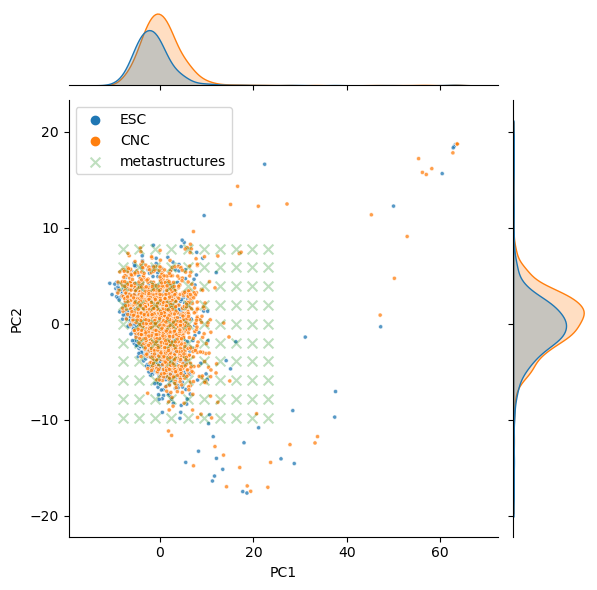

In [10]:
sns.jointplot(x='PC1', y='PC2', data=all_df, marker='.', hue='label', alpha=0.75)
plt.scatter(pc1_grid_flat, pc2_grid_flat, marker='x', color='green', s=50, alpha=0.25, label='metastructures')
plt.legend()
# plt.savefig(save_dir + 'pca_2d_with_metastructure.png', dpi=300, bbox_inches='tight')

In [7]:
# Sort PC2 in descending order while keeping PC1 in ascending order
pc1_pc2_df = pc1_pc2_df.sort_values(by=['PC1', 'PC2'], ascending=[True, False], ignore_index=True)
metastr_from_pca = pca.inverse_transform(pc1_pc2_df[['PC1', 'PC2']])

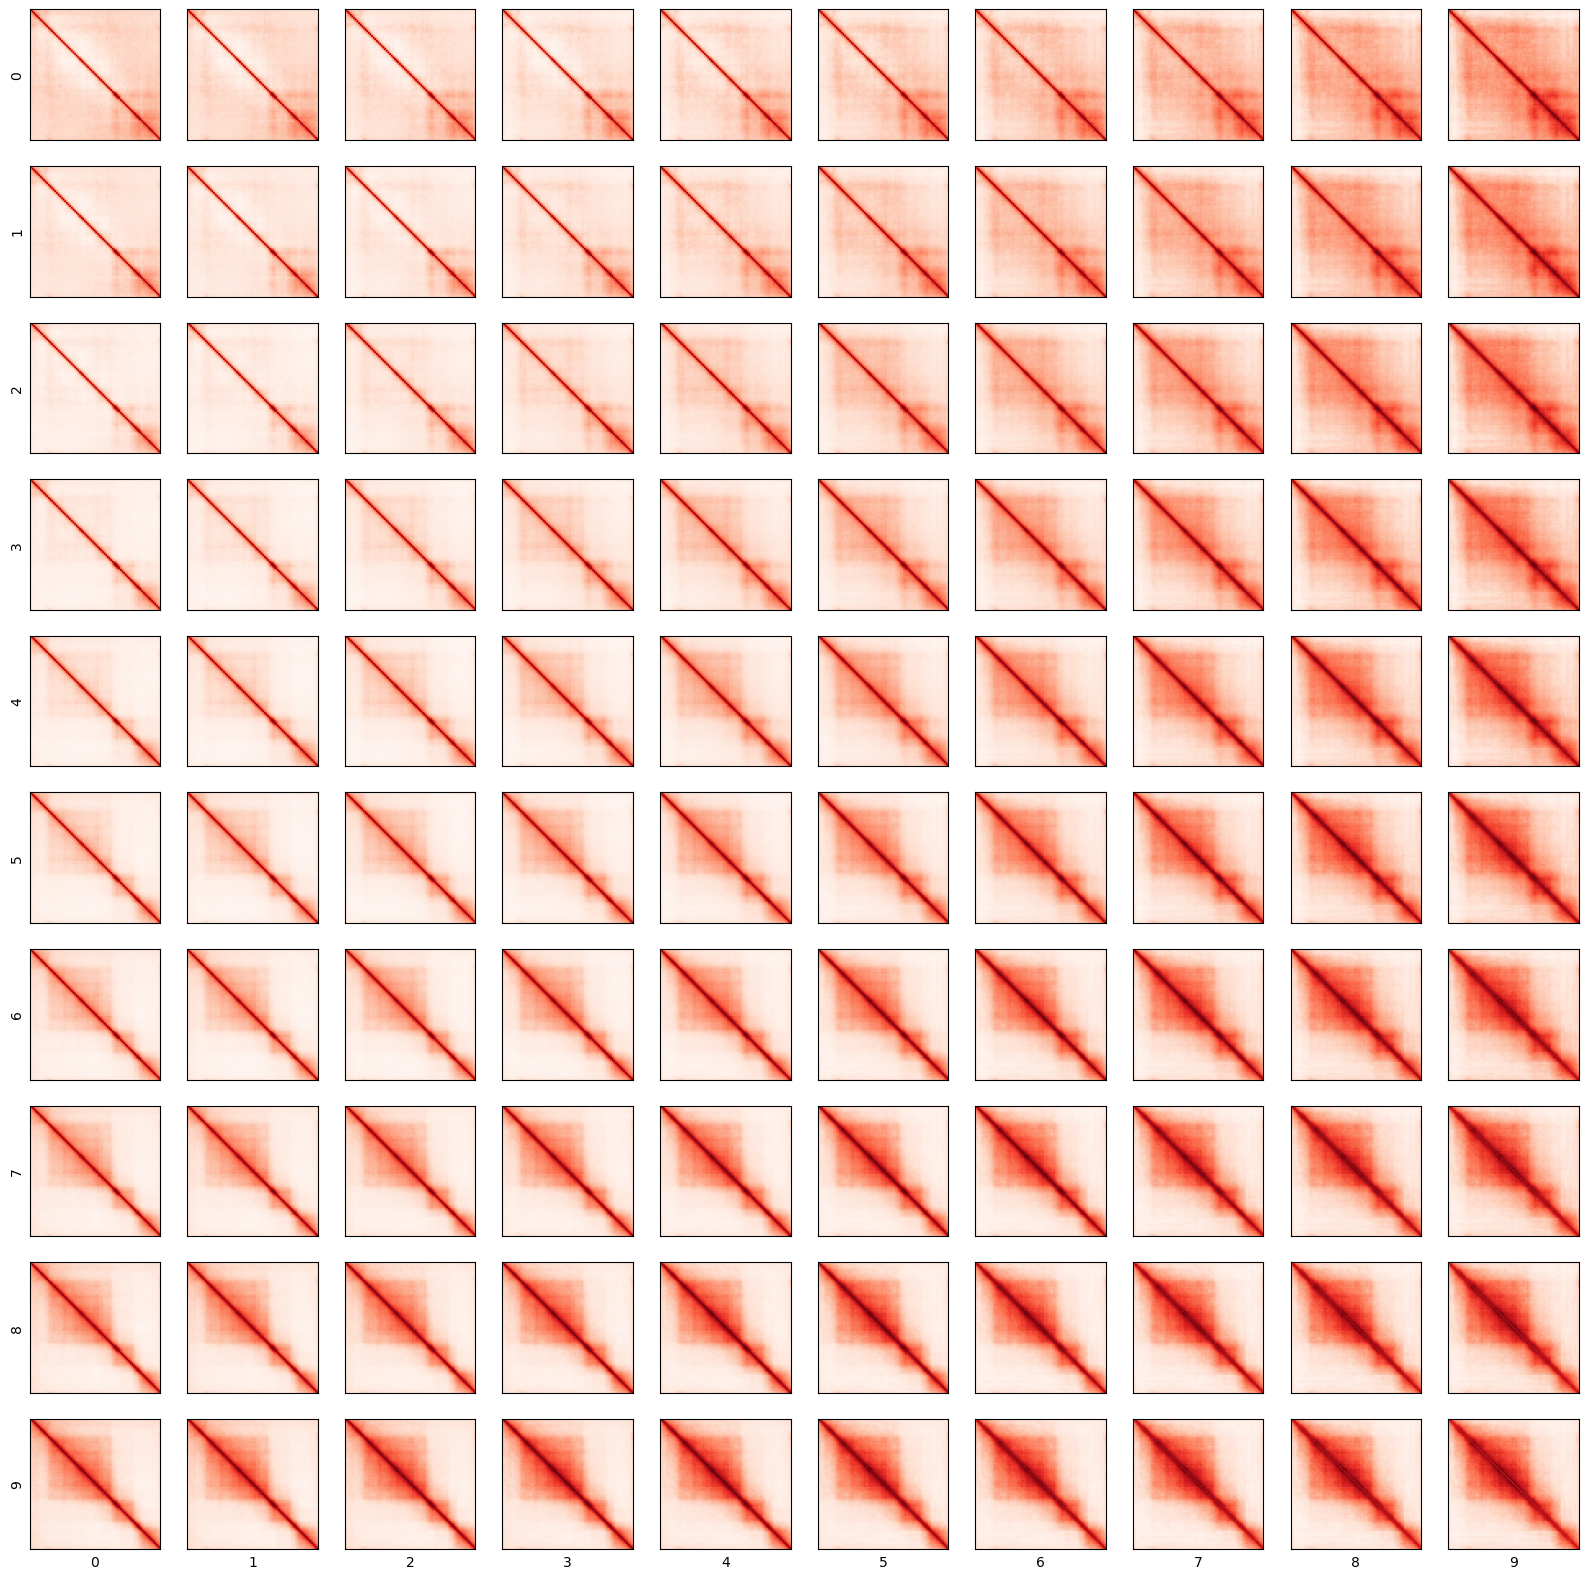

In [9]:
# This is very large so it is slow to plot 
# Plot 50 x 50 grid of metastructures based on PC1 and PC2 

fig, axs = plt.subplots(num_metastructures, num_metastructures, figsize=(20, 20))
for i in range(num_metastructures ** 2):
    ax=axs[i%num_metastructures, i//num_metastructures]
    metastr = metastr_from_pca[i]
    metastr = metastr.reshape((80, 80))
    ax.imshow(metastr, cmap='Reds')
    # ax.set_title(f'M{i}')
    # axs[i//10, i%10].axis('off')
    # if ax is in the first col, add a y label
    if i // num_metastructures == 0:
        ax.set_ylabel(i)
    # if ax is in the last row, add a x label
    if i % num_metastructures == num_metastructures - 1:
        ax.set_xlabel(i//num_metastructures)
        
    # Remove ticks by setting them to an empty list
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.savefig(save_dir + 'contact_maps_sorted_by_pca.png', dpi=300, bbox_inches='tight')